In [1]:
import pandas as pd
import os
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, AlphaDropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D,LayerNormalization, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow_addons.layers import WeightNormalization
from keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\divij\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\divij\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

## Data Preprocessing

In [2]:
# Set the data folder path
data_folder = "data"

# List subfolders in the data folder
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]

# Lists to store small and large subfolders
small_subfolders = []
large_subfolders = []

# Iterate over subfolders
for subfolder in subfolders:
    # Extract subfolder name from the path
    subfolder_name = os.path.basename(subfolder)

    # Read data and labels from CSV files in the subfolder
    data = pd.read_csv(f"{subfolder}/{subfolder_name}" + "_py.dat")
    labels = pd.read_csv(f"{subfolder}/labels_py.dat")
    
    # Check the size of the data to determine if it's a small or large subfolder
    if data.shape[0] > 1000:
        large_subfolders.append(subfolder)
    else:
        small_subfolders.append(subfolder)

# Print the number of small and large subfolders
print("Number of small subfolders:", len(small_subfolders))
print("Number of large subfolders:", len(large_subfolders))


Number of small subfolders: 77
Number of large subfolders: 44


In [3]:
def preprocess_data(subfolder):
    temp_array = []
    subfolder_name = os.path.basename(subfolder)
    print(f"Processing data in subfolder: {subfolder_name}")

    # Load data and labels
    data = pd.read_csv(f"{subfolder}/{subfolder_name}"+"_py.dat")
    labels = pd.read_csv(f"{subfolder}/labels_py.dat")

    # Number of classes
    num_classes = labels.nunique().iloc[0]

    # Split data into train, validation, and test sets
    temp_data, X_test, temp_labels, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(temp_data, temp_labels, test_size=0.25, random_state=42)

    # Convert data to numpy arrays
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    X_val = X_val.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    y_val = y_val.to_numpy()

    # One-hot encode labels
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

## Model Definitions 

In [4]:
def mlp_selu(num_classes):
    model = Sequential()
    model.add(Flatten())

    model.add(Dense(512, activation='selu', kernel_initializer='lecun_normal', bias_initializer='zeros'))
    model.add(AlphaDropout(0.05))

    model.add(Dense(256, activation='selu', kernel_initializer='lecun_normal', bias_initializer='zeros'))
    model.add(AlphaDropout(0.05))
    
    model.add(Dense(num_classes, activation='softmax', kernel_initializer='lecun_normal', bias_initializer='zeros'))

    return model

In [5]:
def mlp_layer_norm(num_classes):
    model = Sequential()
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros'))
    model.add(Dropout(0.05))
    model.add(LayerNormalization())
    
    model.add(Dense(256, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros'))
    model.add(Dropout(0.05))
    model.add(LayerNormalization())
    
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal',bias_initializer='zeros'))

    return model

In [6]:
def mlp_batch_norm(num_classes):
    model = Sequential()
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros'))
    model.add(Dropout(0.05))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal',bias_initializer='zeros'))

    return model

In [7]:
def mlp_weight_norm(num_classes):
    model = Sequential()
    model.add(Flatten())

    model.add(WeightNormalization(Dense(512, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros')))
    model.add(Dropout(0.05))

    model.add(WeightNormalization(Dense(256, activation='relu',kernel_initializer='lecun_normal',bias_initializer='zeros')))
    model.add(Dropout(0.05))
    
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='lecun_normal',bias_initializer='zeros'))

    return model

## Training the Models

In [8]:
def compile_and_fit(model,X_train, y_train, X_val, y_val, batch_size=32, epochs=10):
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, y_val)
    )
    return model

In [9]:
# Specify the list of model creation functions
model_creators = [mlp_selu, mlp_batch_norm, mlp_layer_norm, mlp_weight_norm]
model_names = ["SELU", "Batch Norm", "Layer Norm", "Weight Norm"]

# Lists to store accuracies for each model
accuracies_large = {model_name: [] for model_name in model_names}

for subfolder in large_subfolders[:5]:
    X_train, y_train, X_val, y_val, X_test, y_test, num_classes = preprocess_data(subfolder)

    for model_creator, model_name in zip(model_creators, model_names):
        model = model_creator(num_classes)
        model = compile_and_fit(model, X_train, y_train, X_val, y_val,epochs=100)

        # Evaluate the model on the test set
        score = model.evaluate(X_test, y_test, verbose=0)
        print(f'{model_name} - Test loss: {score[0]}, Test accuracy: {score[1]}')

        # Append accuracy to the corresponding list
        accuracies_large[model_name].append(score[1])

# Print the lists of accuracies
for model_name, accuracy_list in accuracies_large.items():
    print(f'{model_name} accuracies:', accuracy_list)


Processing data in subfolder: abalone

Epoch 1/100


79/79 [==============================] - 1s 6ms/step - loss: 0.9180 - accuracy: 0.5948 - val_loss: 1.0479 - val_accuracy: 0.6084
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 0.8495 - accuracy: 0.6200 - val_loss: 0.8207 - val_accuracy: 0.6108
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 0.8071 - accuracy: 0.6220 - val_loss: 0.7972 - val_accuracy: 0.6168
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.7788 - accuracy: 0.6419 - val_loss: 0.8696 - val_accuracy: 0.6407
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.7737 - accuracy: 0.6379 - val_loss: 0.8488 - val_accuracy: 0.6383
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.7684 - accuracy: 0.6323 - val_loss: 0.8573 - val_accuracy: 0.6383
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 0.7520 - accuracy: 0.6551 - val_loss: 0.

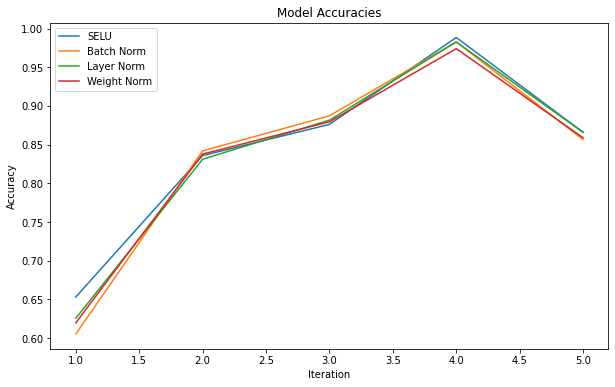

In [10]:
# Plotting the accuracies
plt.figure(figsize=(10, 6))

for model_name, accuracy_list in accuracies_large.items():
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label=model_name)

plt.title('Model Accuracies')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
from scipy.stats import wilcoxon

# Find the best-performing model
best_model = max(accuracies_large, key=lambda k: np.mean(accuracies_large[k]))

# Print the best model
print(f"\nBest Performing Model: {best_model} with average accuracy {np.mean(accuracies_large[best_model])}\n")

# Compare other models to the best model
p_values_to_best_model = {model_name: [] for model_name in model_names if model_name != best_model}
for model_name in p_values_to_best_model:
    _, p_value = wilcoxon(accuracies_large[best_model], accuracies_large[model_name])
    p_values_to_best_model[model_name].append(p_value)

print("P-values compared to the best model:")
for model_name, p_value in p_values_to_best_model.items():
    print(f'{model_name} vs. {best_model}: {p_value[0]}')



Best Performing Model: SELU with average accuracy 0.8438690066337585

P-values compared to the best model:
Batch Norm vs. SELU: 1.1837050725550384e-06
Layer Norm vs. SELU: 0.012606240005210986
Weight Norm vs. SELU: 1.4146295505402953e-07


In [3]:
from tabulate import tabulate

methods = ['SNN', 'BatchNorm', 'LayerNorm', 'WeightNorm']
accuracy = [1, 1.1837050725550384e-06, 0.012606240005210986, 1.4146295505402953e-07]

# Creating a list of tuples for tabular data
data = list(zip(methods, accuracy))

# Creating a table and displaying it
table = tabulate(data, headers=['Methods', 'p-value'], tablefmt='pretty')
print(table)

+------------+------------------------+
|  Methods   |        p-value         |
+------------+------------------------+
|    SNN     |           1            |
| BatchNorm  | 1.1837050725550384e-06 |
| LayerNorm  |  0.012606240005210986  |
| WeightNorm | 1.4146295505402953e-07 |
+------------+------------------------+
